STREME utilizes the ZOOPS (zero or one occurrence per sequence) model -> for sensitivity experiments, this enables
STREME to work with diluted data sets where only a fraction of input sequences actually contains the desired motif(s).

Our loss quickly begins to struggle with diluted input data. Try to find a loss function that does not penalize input
sequences without any good motif.

In [9]:
import logging
import numpy as np
from pathlib import Path
import sys

from modules import ModelDataSet, plotting, ProfileFindingSetup, SequenceRepresentation, training, utils

logger = logging.getLogger()
logging.basicConfig(format="%(asctime)s %(levelname)s: %(message)s", 
                    encoding='utf-8', level=logging.DEBUG)

In [2]:
# set some args
SEED = 42
MAXSEQS = 1000
mode = 'DNA'
phylo_t = 0

In [3]:
# load data

fasta = Path('../data/STREME_benchmark_data/diluted_ds_primary/1.00/wgEncodeAwgTfbsBroadK562CtcfUniPk.narrowPeak.centered100bp.1.00pure.fasta')
assert fasta.is_file(), f"[ERROR] >>> Input file '{fasta}' not found"


if mode == 'DNA':
    datamode = ModelDataSet.DataMode.DNA
else:
    if phylo_t == 0:
        datamode = ModelDataSet.DataMode.Translated
    else:
        logging.warning("[main] Phylo_t is not 0.0 and data mode is set to 'Translated'. Setting data mode to " \
                        + "'Translated_noStop', using only 20-letter aa alphabet without stop codon.")
        datamode = ModelDataSet.DataMode.Translated_noStop
        
logging.info(f"[main] Data mode: {datamode}")

# === LOAD DATA ===

logging.info("[main] Loading sequences")
sequences = SequenceRepresentation.loadFasta_agnostic(fasta)
if MAXSEQS is not None and MAXSEQS < len(sequences):
    logging.info(f"[main] Limiting data to {MAXSEQS}/{len(sequences)} sequences from the input fasta")
    sequences = sequences[:MAXSEQS]

genomes = [SequenceRepresentation.Genome([s]) for s in sequences]

2025-02-21 16:32:12,315 INFO: [main] Data mode: DataMode.DNA
2025-02-21 16:32:12,315 INFO: [main] Loading sequences
2025-02-21 16:32:13,236 INFO: [main] Limiting data to 1000/51992 sequences from the input fasta


In [4]:
genomes[:5]

[Genome from chr22:22901677-22901578 with 1 chromosomes: 0 (1 sequence[s]),
 Genome from chr22:20918741-20918642 with 1 chromosomes: 0 (1 sequence[s]),
 Genome from chr22:23285067-23284968 with 1 chromosomes: 0 (1 sequence[s]),
 Genome from chr22:21239921-21239822 with 1 chromosomes: 0 (1 sequence[s]),
 Genome from chr22:23624139-23624040 with 1 chromosomes: 0 (1 sequence[s])]

In [5]:
# more settings
tile_size = 100
tiles_per_X = 1
batch_size = 1
prefetch = 3

In [6]:
data = ModelDataSet.ModelDataSet(genomes, datamode,
                                 tile_size=tile_size, tiles_per_X=tiles_per_X,
                                 batch_size=batch_size, prefetch=prefetch)

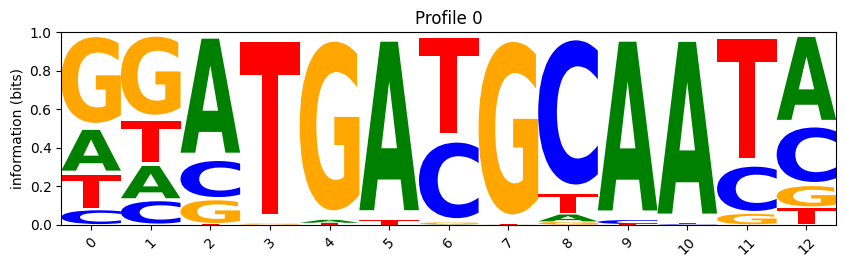

In [19]:
# get the desired reference motif for this experiment
ref_motifs = utils.readMemeFile(Path('../data/STREME_benchmark_data/01_reference_motifs/motif_databases/EUKARYOTE/jolma2013.meme'))

ref_motif = ref_motifs['ATF4_DBD']
ref_profile = np.expand_dims(ref_motif, axis=2)

plotting.plotLogo(ref_profile, alphabet=[c for c in 'ACGT'])

In [18]:
# more settings
U = 200
k = 12
midK = 8
s = 0
gamma = 1.0
l2 = 0.01
match_score_factor = 0.7
learning_rate = 2.0
lr_patience = 5
lr_factor = 0.75
rho = 0.0
sigma = 1.0
profile_plateau = 10
profile_plateau_dev = 150
n_best_profiles = 5

enforceU = False
minU = 10
minOcc = 8
overlapTilesize = 6

do_not_train = False

In [19]:
trainsetup = ProfileFindingSetup.ProfileFindingTrainingSetup(data,
                                                             U = U, k = k, 
                                                             midK = midK, s = s, 
                                                             epochs = 350, gamma = gamma, l2 = l2,
                                                             match_score_factor = match_score_factor,
                                                             learning_rate = learning_rate,
                                                             lr_patience = lr_patience,
                                                             lr_factor = lr_factor,
                                                             rho = rho, sigma = sigma,
                                                             profile_plateau = profile_plateau,
                                                             profile_plateau_dev = profile_plateau_dev,
                                                             n_best_profiles = n_best_profiles,
                                                             phylo_t = phylo_t)
                                                             
trainsetup.initializeProfiles_kmers(enforceU=enforceU, 
                                    minU=minU, minOcc=minOcc,
                                    overlapTilesize=overlapTilesize,
                                    plot=False)

evaluator = training.MultiTrainingEvaluation()

logging.info(f"[main] Start training and evaluation")
training.trainAndEvaluate(fasta.name, trainsetup, evaluator, 
                          outdir=None,  # type: ignore
                          do_not_train=do_not_train,
                          rand_seed=SEED) # type: ignore

2025-02-21 15:41:39,943 INFO: [ProfileFindingSetup.ProfileFindingTrainingSetup.initializeProfiles] >>> Number of profiles: 200
2025-02-21 15:41:39,951 INFO: [main] Start training and evaluation
2025-02-21 15:41:39.987340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-21 15:41:39.990391: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-02-21 15:41:40,044 DEBUG: [model.__init__] >>> setting tf global seed to

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-02-21 15:41:41,823 DEBUG: [model.getR] >>> nan in P: Tensor("cond/Any:0", shape=(200,), dtype=bool) Tensor("cond/boolean_mask/GatherV2:0", shape=(12, 4, None), dtype=float32)
2025-02-21 15:41:42,317 WARNING: AutoGraph could not transform <bound method Socket.send of <zmq.Socket(zmq.PUSH) at 0x7fe984ee37c0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-02-21 15:41:42,551 DEBUG: [model.getR] >>> Q: [0.18566187 0.31433815 0.31433815 0.18566187]
2025-02-21 15:41:42,577 DEBUG: [model.getZ] >>> nan in R
2025-02-21 15:41:42,599 DEBUG: [model.getZ] >>> nan in X
2025-02-21 15:41:42,620 DEBUG: [model.getZ] >>> nan in Z
2025-02-21 15:41:42,762 DEBUG: [model.getR] >>> nan in P: Tensor("cond/Any:0", shape=(200,), dtype=bool) Tensor("cond/boolean_mask/GatherV2:0", shape=(12, 4, None), dtype=float32)
2025-02-21 15:41:42,781 DEBUG: [model.getR] >>> Q: [0.18566187 0.31433815 0.31433815 0.18566187]
2025-02-21 15:41:42,805 DEBUG: [model.getZ] >>> nan in R
2025-02-21 15:41:42,827 DEBUG: [model.getZ] >>> nan in X
2025-02-21 15:41:42,848 DEBUG: [model.getZ] >>> nan in Z
2025-02-21 15:41:43.488400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-21 15:41:43.599086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_R

In [28]:
evaluator.trainings[0].motifs.motifs.shape

(12, 4, 5)